<a href="https://colab.research.google.com/github/jerryzhu1/Have-fun-with-deep-learning----pytorch-tensorflow/blob/master/nlp_pytorch_new_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import pandas as pd
import re
import pickle
from nltk import word_tokenize
from nltk.stem import *

import nltk
from nltk.corpus import stopwords

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_df = pd.read_pickle("drive/My Drive/word2vec/data_vectorized.pickle")

In [0]:
len(data_df)

1000000

In [0]:
# data_df = data_df.iloc[:500000,]

In [0]:
with open('drive/My Drive/word2vec/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [0]:
weights = np.loadtxt("drive/My Drive/word2vec/embedding_weights.txt")


In [0]:
data_df['X'] = data_df['X'].apply(lambda x: [int(i) for i in x])
data_df['Y'] = data_df['Y'].apply(lambda x: [int(i) for i in x])

In [0]:
import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [0]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data_df['X'], data_df['Y'], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [0]:
del data_df

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.stack([torch.Tensor(i) for i in X_train]), torch.stack([torch.Tensor(i) for i in y_train]))
valid_data = TensorDataset(torch.stack([torch.Tensor(i) for i in X_val]), torch.stack([torch.Tensor(i) for i in y_val]))
test_data = TensorDataset(torch.stack([torch.Tensor(i) for i in X_test]), torch.stack([torch.Tensor(i) for i in y_test]))

batch_size = 2000

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
del X_train_val, X_test, y_train_val, y_test
del X_train, X_val, y_train, y_val

In [0]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) 
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) 
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([2000, 250])
Sample input: 
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.5200e+02, 1.1000e+01,
         8.0800e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.0000e+01, 1.6390e+03,
         7.4700e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.4600e+02, 9.1020e+03,
         1.7000e+01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.0000e+01, 5.3000e+01,
         1.1100e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.2200e+02, 5.0000e+00,
         1.7800e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.1230e+03, 4.1930e+03,
         1.9000e+01]])

Sample label size:  torch.Size([2000, 5])
Sample label: 
 tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]])


In [0]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [0]:
len(tokenizer.index_docs)

580161

In [0]:
weights_matrix = torch.stack([torch.tensor(i, dtype=torch.float32) for i in weights])

In [0]:

class SentimentRNN(nn.Module):
 
    def create_emb_layer(self, weights_matrix, non_trainable=False):
        num_embeddings, embedding_dim = weights_matrix.size()
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})
        if non_trainable:
            emb_layer.weight.requires_grad = False

        return emb_layer, num_embeddings, embedding_dim


    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
  
        self.embedding, num_embeddings, embedding_dim = self.create_emb_layer(weights_matrix, True)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True,
                           bidirectional=False)
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
       
        self.sig1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.sm = nn.Softmax(dim=1)
        
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = self.sig1(out)
        
        out = self.fc2(out)
        out = out.view(batch_size, self.output_size, -1)
        out = out[:, :, -1] 
        out = self.sm(out)
        
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        if(train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [0]:
vocab_size, embedding_dim = weights_matrix.size() 
output_size = 5

hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.1)

print(net)


SentimentRNN(
  (embedding): Embedding(10000, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.3)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (sig1): ReLU()
  (fc2): Linear(in_features=256, out_features=5, bias=True)
  (sm): Softmax()
)


Epoch: 1/10... Step: 50... Loss: 0.758146... Val Loss: 0.758142


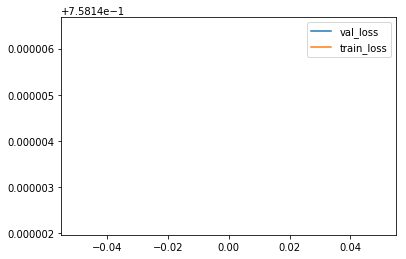

Epoch: 1/10... Step: 100... Loss: 0.758148... Val Loss: 0.758141


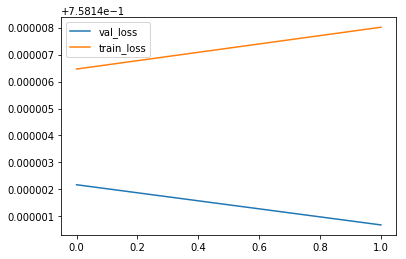

Epoch: 1/10... Step: 150... Loss: 0.758142... Val Loss: 0.758139


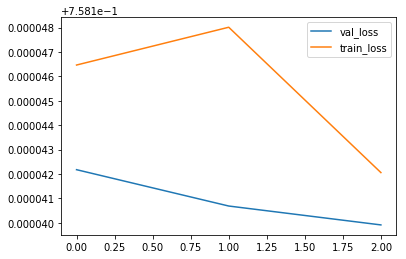

Epoch: 1/10... Step: 200... Loss: 0.758139... Val Loss: 0.758138


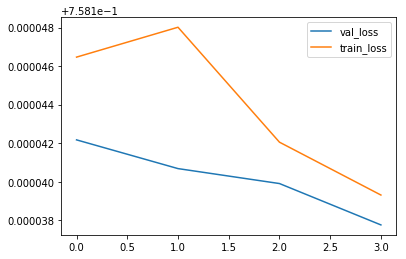

Epoch: 1/10... Step: 250... Loss: 0.758142... Val Loss: 0.758137


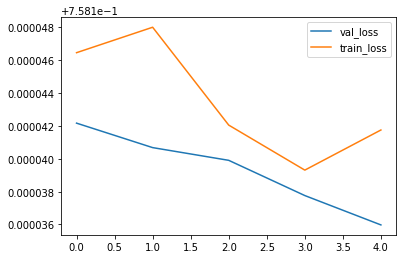

Epoch: 1/10... Step: 300... Loss: 0.758137... Val Loss: 0.758136


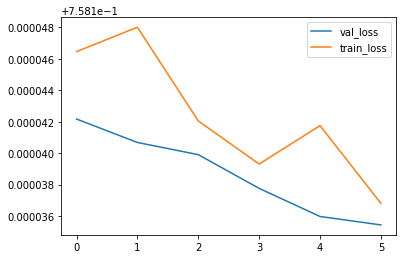

Epoch: 1/10... Step: 350... Loss: 0.758134... Val Loss: 0.758134


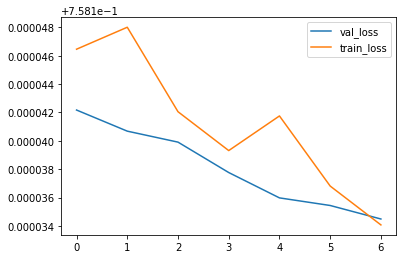

Epoch: 2/10... Step: 400... Loss: 0.758135... Val Loss: 0.758133


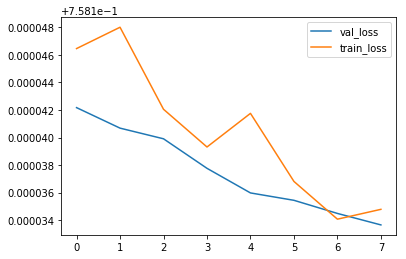

Epoch: 2/10... Step: 450... Loss: 0.758139... Val Loss: 0.758133


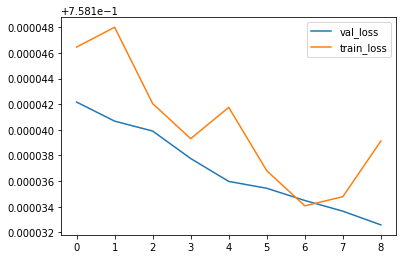

Epoch: 2/10... Step: 500... Loss: 0.758136... Val Loss: 0.758132


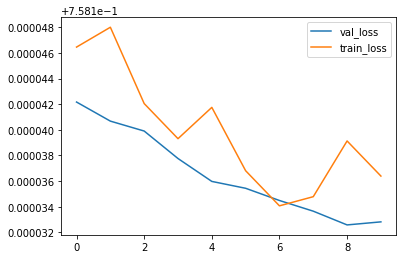

Epoch: 2/10... Step: 550... Loss: 0.758137... Val Loss: 0.758131


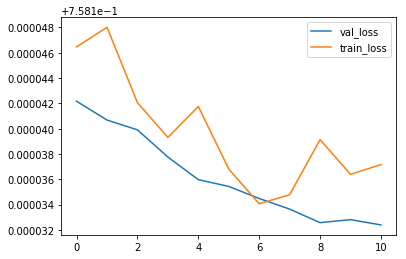

Epoch: 2/10... Step: 600... Loss: 0.758129... Val Loss: 0.758130


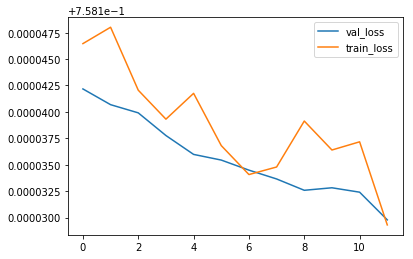

Epoch: 2/10... Step: 650... Loss: 0.758133... Val Loss: 0.758130


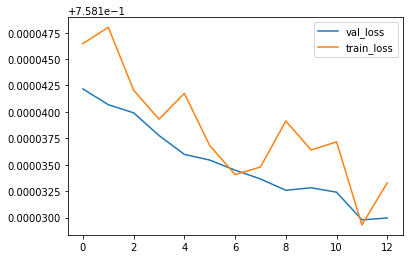

Epoch: 2/10... Step: 700... Loss: 0.758127... Val Loss: 0.758129


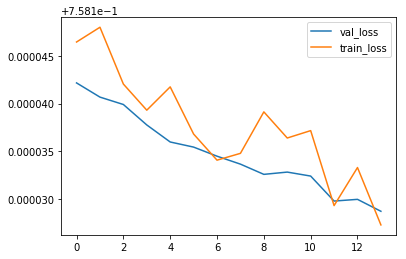

Epoch: 3/10... Step: 750... Loss: 0.758130... Val Loss: 0.758128


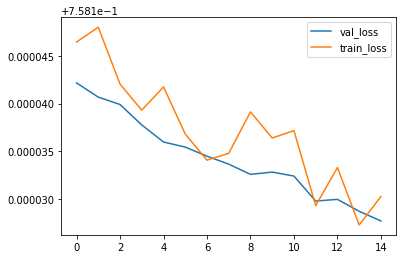

Epoch: 3/10... Step: 800... Loss: 0.758130... Val Loss: 0.758128


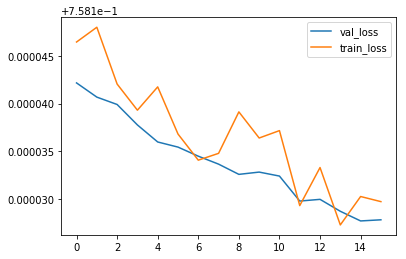

Epoch: 3/10... Step: 850... Loss: 0.758136... Val Loss: 0.758127


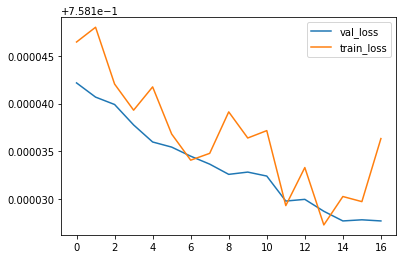

Epoch: 3/10... Step: 900... Loss: 0.758130... Val Loss: 0.758127


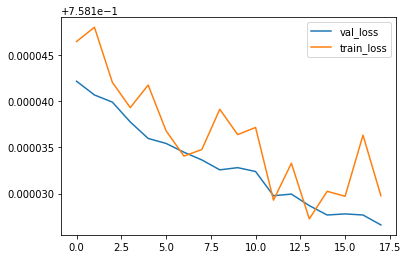

Epoch: 3/10... Step: 950... Loss: 0.758132... Val Loss: 0.758126


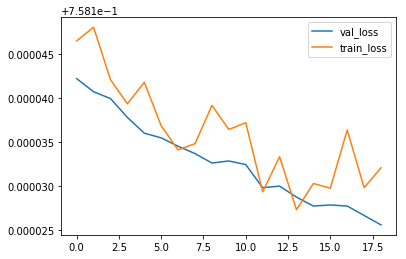

Epoch: 3/10... Step: 1000... Loss: 0.758130... Val Loss: 0.758126


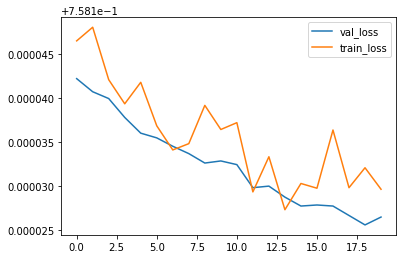

Epoch: 3/10... Step: 1050... Loss: 0.758126... Val Loss: 0.758125


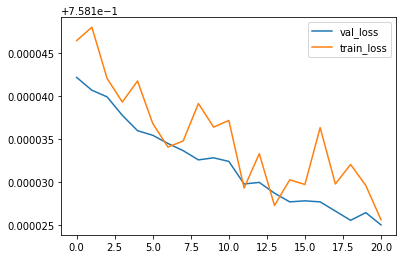

Epoch: 4/10... Step: 1100... Loss: 0.758129... Val Loss: 0.758125


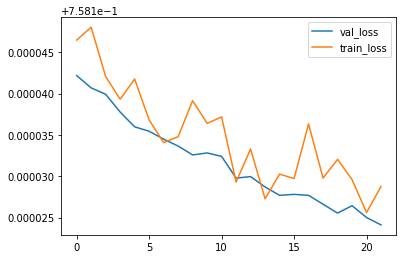

Epoch: 4/10... Step: 1150... Loss: 0.758126... Val Loss: 0.758124


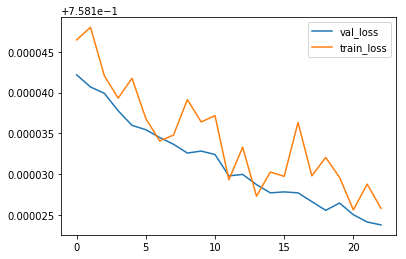

Epoch: 4/10... Step: 1200... Loss: 0.758132... Val Loss: 0.758124


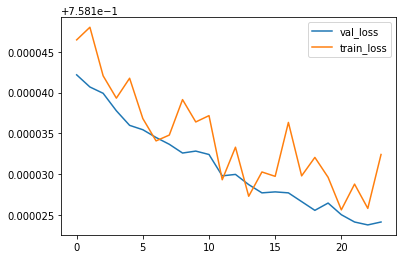

Epoch: 4/10... Step: 1250... Loss: 0.758126... Val Loss: 0.758123


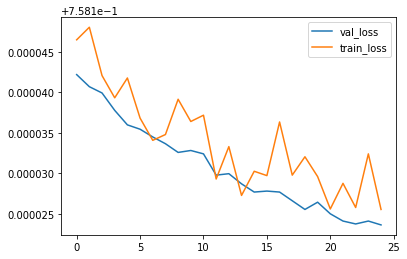

Epoch: 4/10... Step: 1300... Loss: 0.758126... Val Loss: 0.758123


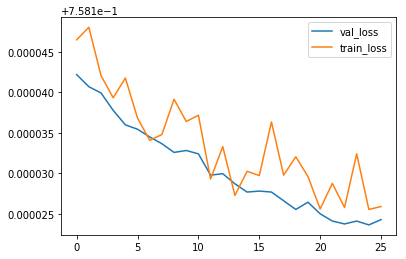

Epoch: 4/10... Step: 1350... Loss: 0.758122... Val Loss: 0.758123


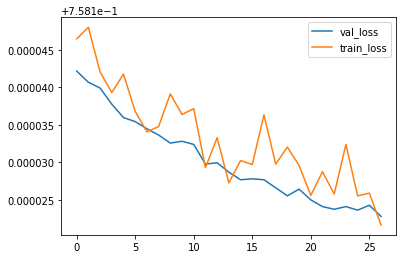

Epoch: 4/10... Step: 1400... Loss: 0.758123... Val Loss: 0.758122


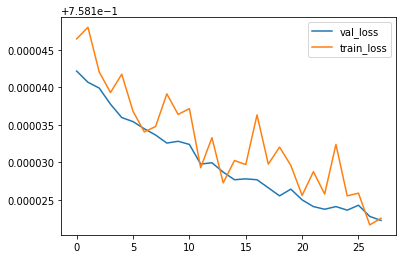

Epoch: 5/10... Step: 1450... Loss: 0.758127... Val Loss: 0.758122


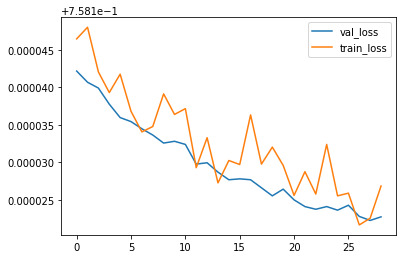

Epoch: 5/10... Step: 1500... Loss: 0.758116... Val Loss: 0.758122


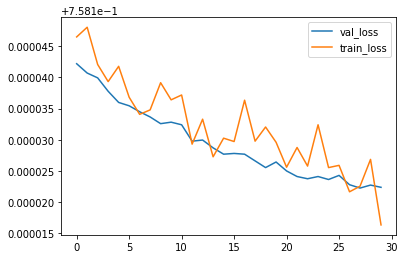

Epoch: 5/10... Step: 1550... Loss: 0.758121... Val Loss: 0.758122


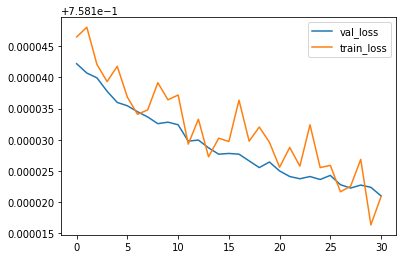

Epoch: 5/10... Step: 1600... Loss: 0.758124... Val Loss: 0.758121


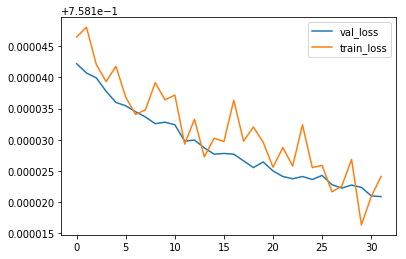

Epoch: 5/10... Step: 1650... Loss: 0.758122... Val Loss: 0.758121


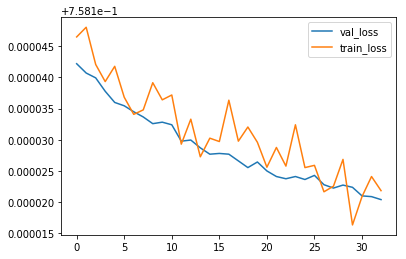

Epoch: 5/10... Step: 1700... Loss: 0.758127... Val Loss: 0.758121


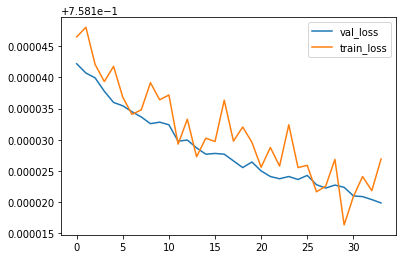

Epoch: 5/10... Step: 1750... Loss: 0.758120... Val Loss: 0.758120


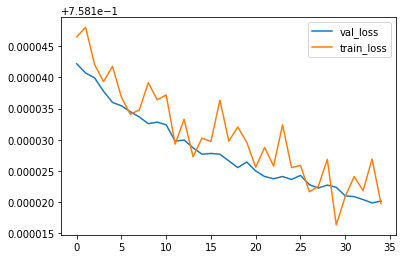

Epoch: 5/10... Step: 1800... Loss: 0.758124... Val Loss: 0.758120


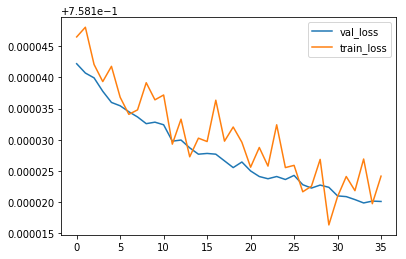

Epoch: 6/10... Step: 1850... Loss: 0.758129... Val Loss: 0.758120


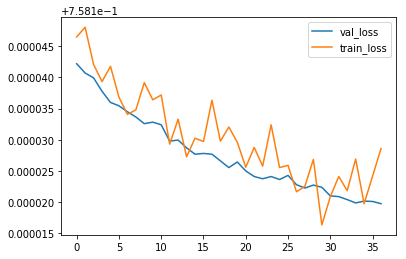

Epoch: 6/10... Step: 1900... Loss: 0.758115... Val Loss: 0.758120


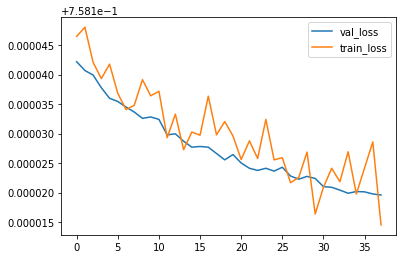

Epoch: 6/10... Step: 1950... Loss: 0.758118... Val Loss: 0.758120


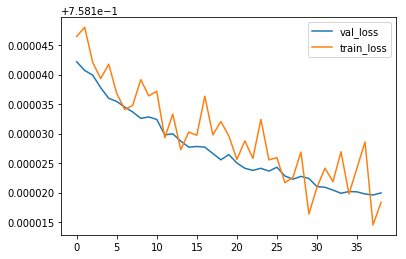

Epoch: 6/10... Step: 2000... Loss: 0.758116... Val Loss: 0.758120


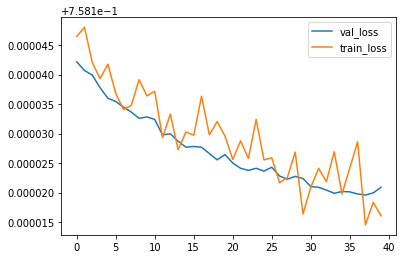

Epoch: 6/10... Step: 2050... Loss: 0.758122... Val Loss: 0.758119


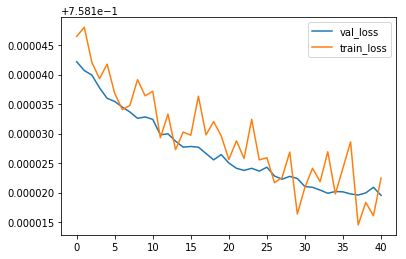

Epoch: 6/10... Step: 2100... Loss: 0.758122... Val Loss: 0.758119


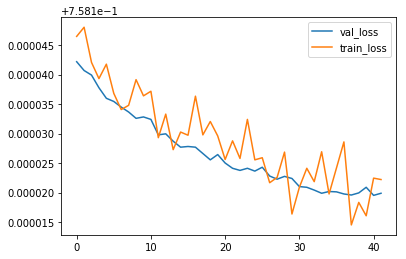

Epoch: 6/10... Step: 2150... Loss: 0.758127... Val Loss: 0.758119


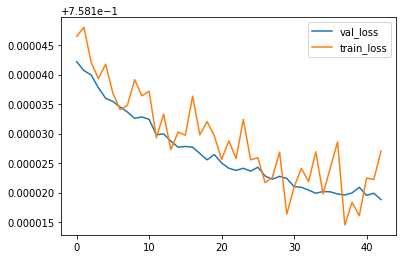

Epoch: 7/10... Step: 2200... Loss: 0.758125... Val Loss: 0.758119


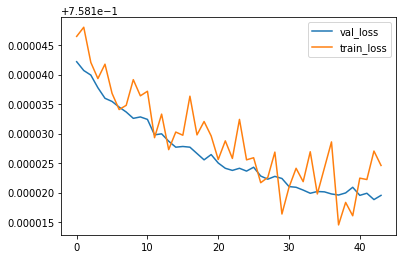

Epoch: 7/10... Step: 2250... Loss: 0.758115... Val Loss: 0.758119


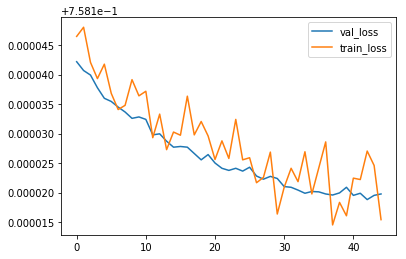

Epoch: 7/10... Step: 2300... Loss: 0.758121... Val Loss: 0.758119


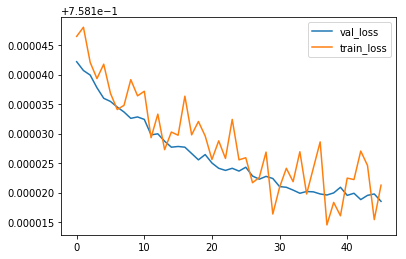

Epoch: 7/10... Step: 2350... Loss: 0.758114... Val Loss: 0.758118


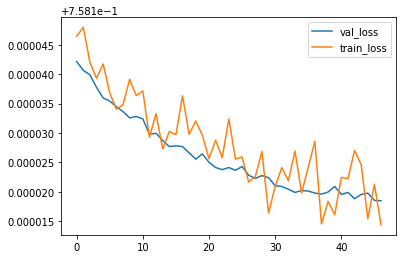

Epoch: 7/10... Step: 2400... Loss: 0.758122... Val Loss: 0.758118


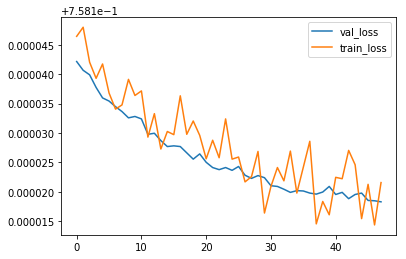

Epoch: 7/10... Step: 2450... Loss: 0.758119... Val Loss: 0.758118


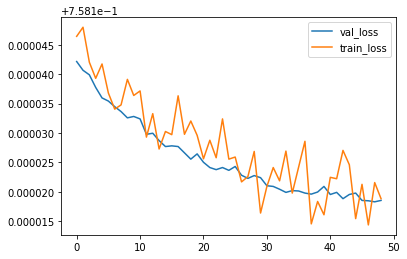

Epoch: 7/10... Step: 2500... Loss: 0.758120... Val Loss: 0.758118


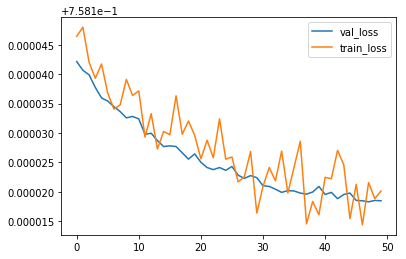

Epoch: 8/10... Step: 2550... Loss: 0.758118... Val Loss: 0.758118


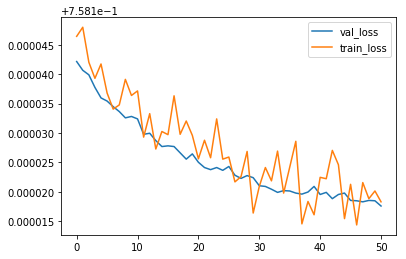

Epoch: 8/10... Step: 2600... Loss: 0.758118... Val Loss: 0.758118


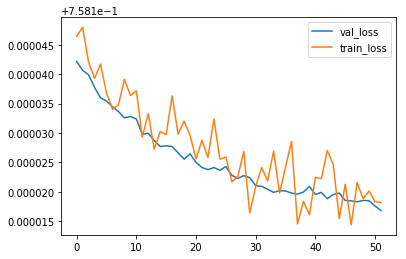

Epoch: 8/10... Step: 2650... Loss: 0.758116... Val Loss: 0.758118


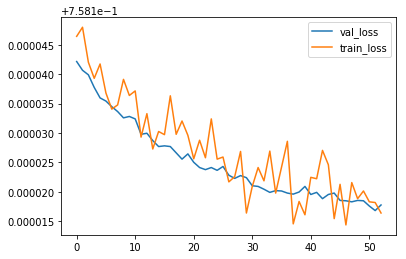

Epoch: 8/10... Step: 2700... Loss: 0.758120... Val Loss: 0.758118


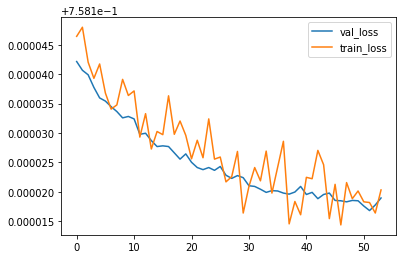

Epoch: 8/10... Step: 2750... Loss: 0.758120... Val Loss: 0.758118


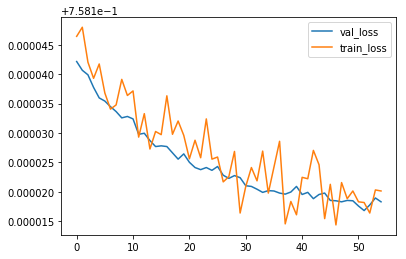

Epoch: 8/10... Step: 2800... Loss: 0.758123... Val Loss: 0.758118


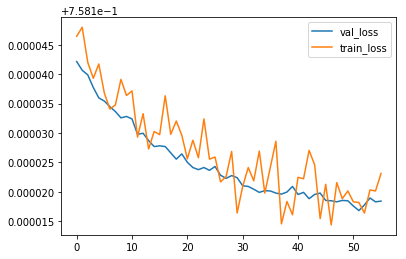

Epoch: 8/10... Step: 2850... Loss: 0.758124... Val Loss: 0.758117


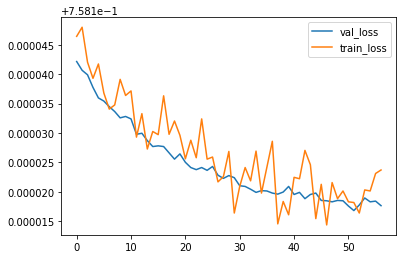

Epoch: 9/10... Step: 2900... Loss: 0.758123... Val Loss: 0.758117


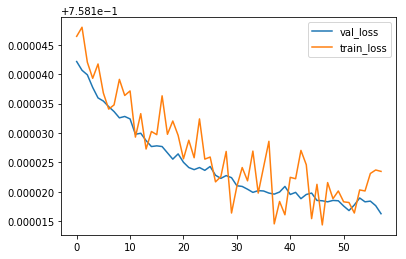

Epoch: 9/10... Step: 2950... Loss: 0.758123... Val Loss: 0.758117


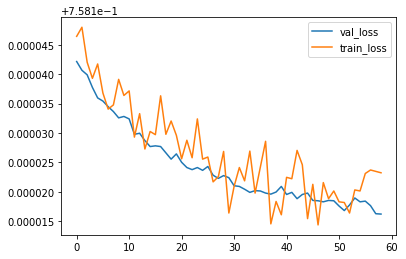

Epoch: 9/10... Step: 3000... Loss: 0.758123... Val Loss: 0.758117


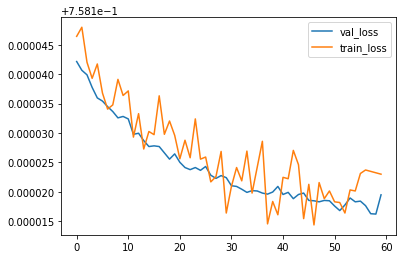

Epoch: 9/10... Step: 3050... Loss: 0.758118... Val Loss: 0.758117


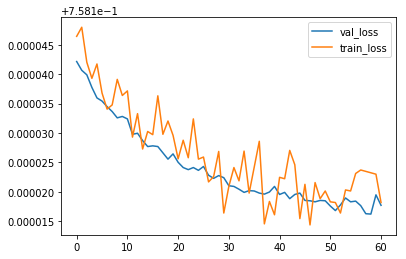

Epoch: 9/10... Step: 3100... Loss: 0.758115... Val Loss: 0.758117


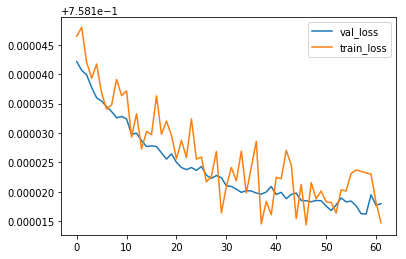

Epoch: 9/10... Step: 3150... Loss: 0.758116... Val Loss: 0.758117


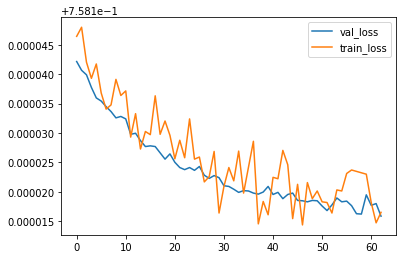

Epoch: 9/10... Step: 3200... Loss: 0.758120... Val Loss: 0.758117


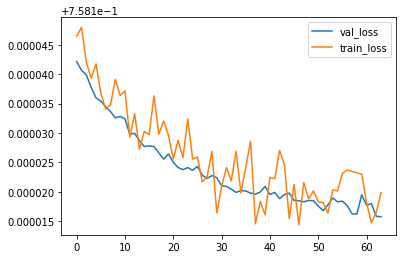

Epoch: 10/10... Step: 3250... Loss: 0.758121... Val Loss: 0.758117


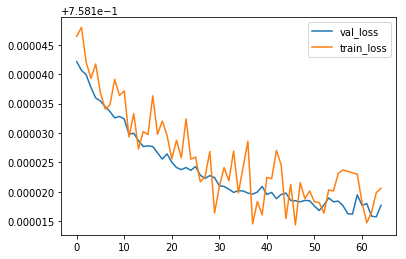

Epoch: 10/10... Step: 3300... Loss: 0.758117... Val Loss: 0.758117


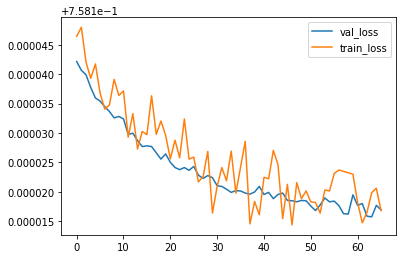

Epoch: 10/10... Step: 3350... Loss: 0.758118... Val Loss: 0.758117


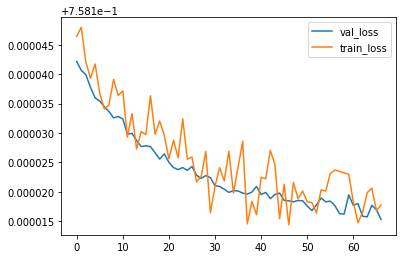

Epoch: 10/10... Step: 3400... Loss: 0.758116... Val Loss: 0.758117


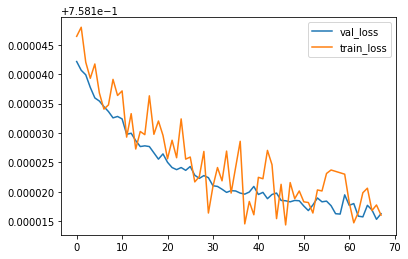

Epoch: 10/10... Step: 3450... Loss: 0.758122... Val Loss: 0.758117


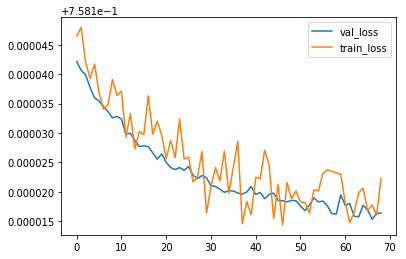

Epoch: 10/10... Step: 3500... Loss: 0.758116... Val Loss: 0.758117


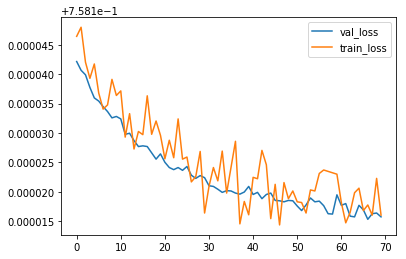

Epoch: 10/10... Step: 3550... Loss: 0.758118... Val Loss: 0.758117


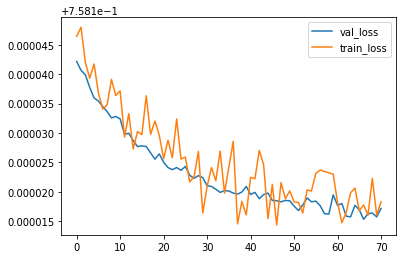

Epoch: 10/10... Step: 3600... Loss: 0.758114... Val Loss: 0.758117


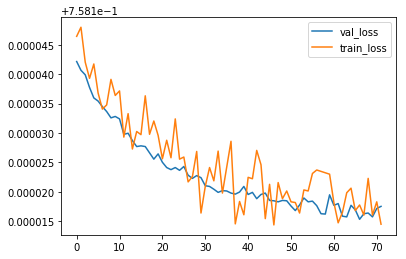

In [0]:
lr=0.1
momentum=0.8
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(reduction='mean')
# criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()

# optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)


epochs = 10 
counter = 0
print_every = 50
clip=5 

if(train_on_gpu):
    net.cuda()

    

loss_hist_val_l = []
loss_hist_train_l = []

net.train()
for e in range(epochs):
    h = net.init_hidden(batch_size)

    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        
        inputs = inputs.type(torch.int64)
        labels = labels.type(torch.float)
        h = tuple([each.data for each in h])

        net.zero_grad()

        output, h = net(inputs, h)
        loss = criterion(output.squeeze(), labels)
        
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        if counter % print_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                  val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.int64)
                labels = labels.type(torch.float)
        
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels)
            
                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                #   "Val Loss: {:.6f}".format(val_loss.item()))
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            loss_hist_val_l.append(val_loss.item())
            loss_hist_train_l.append(loss.item())

            plt.plot(loss_hist_val_l, label='val_loss')
            plt.plot(loss_hist_train_l, label='train_loss')
            plt.legend(loc='best')
            plt.show()
            
    scheduler.step()
                        

In [0]:
total_N = 0.
correct_N = 0.
y_true = []
y_predict = []

for inputs, labels in train_loader:
    counter += 1

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    inputs = inputs.type(torch.int64)
    labels = labels.type(torch.float)
    
    h = net.init_hidden(batch_size)

    net.eval()
    outputs, h = net(inputs, h)
    
    _, indices_output = outputs.max(1)
    _, indices_labels = labels.max(1)
    
    y_predict += indices_output.squeeze().tolist()
    y_true += indices_labels.squeeze().tolist()

    total_N += len(labels)
    correct_N += (indices_labels == indices_output).sum().item()
    
print('Total number: {}, correct number: {}, accuracy: {}'. format(total_N, correct_N, correct_N / total_N))

Total number: 720000.0, correct number: 341410.0, accuracy: 0.47418055555555555


In [0]:
y_predict

Confusion matrix, without normalization
[[ 69045   1809   4192  10507  20319]
 [ 31954   1076   2776   7454  15131]
 [ 29218   1177   3762  12722  33799]
 [ 28051   1554   5630  23364 101054]
 [ 34535   1559   5454  29695 244163]]
Normalized confusion matrix
[[0.65 0.02 0.04 0.1  0.19]
 [0.55 0.02 0.05 0.13 0.26]
 [0.36 0.01 0.05 0.16 0.42]
 [0.18 0.01 0.04 0.15 0.63]
 [0.11 0.   0.02 0.09 0.77]]


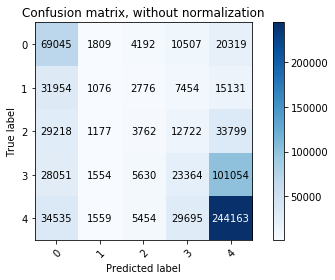

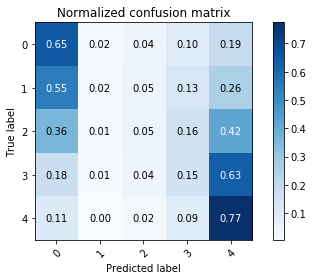

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_predict, 
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_true, y_predict,  normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:


# Instantiate the model w/ hyperparams
vocab_size, embedding_dim = weights_matrix.size() # +1 for zero padding + our word tokens
output_size = 5
# embedding_dim = len(weights_matrix[0]) 
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.1)

print(net)


In [0]:
# loss and optimization functions
lr=0.1
momentum=0.8
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(reduction='mean')
# criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()

# optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)


# training params

epochs = 10 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 50
clip=5 # gradient clipping



# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

    

loss_hist_val_l = []
loss_hist_train_l = []

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        
        inputs = inputs.type(torch.int64)
        labels = labels.type(torch.float)
        
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
#         print('H:')
#         print(len(h))
#         print(h)
#         print('OUTPUT:')
#         print(output)
#         print('OUTPUT above')
#         print()
        # calculate the loss and perform backprop
#         loss = criterion(output.squeeze(), labels.float())
            
#         print(output.max(dim=-1).float())
#         print('before loss')
#         print(labels.float())
#         loss = criterion(output.max(dim=-1).float(), labels.float())
        # print(output.squeeze())
        # print(labels)
        loss = criterion(output.squeeze(), labels)
        
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.int64)
                labels = labels.type(torch.float)
        
                output, val_h = net(inputs, val_h)
#                 val_loss = criterion(output.squeeze(), labels.float())
                val_loss = criterion(output.squeeze(), labels)
            
                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(val_loss.item()))
                #   "Val Loss: {:.6f}".format(np.mean(val_losses)))
            loss_hist_val_l.append(val_loss.item())
            loss_hist_train_l.append(loss.item())

            plt.plot(loss_hist_val_l, label='val_loss')
            plt.plot(loss_hist_train_l, label='train_loss')
            plt.legend(loc='best')
            plt.show()
            
    scheduler.step()
                        

In [0]:
torch.save(net.state_dict(), "drive/My Drive/word2vec/model_1")